## Make a figure showing (sens, err) traces for different models/regularizations

Notes:
 - you need the data stored locally in counterexamples/counterexample_v3.0
 - Due to legacy data storage, there are lots of different routines for loading data. Sorry.
 - There is a mixture of two run modes here: **agg results** are contained in a dataframe where every row is a different model, and the row values correspond to that model's optimal validation score. **trace results** are contained in a dataframe where every row is a different model _and epoch_, and selecting by 'model_num' gives a model's entire history (sensitivity, error, etc.)

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import pandas as pd

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import boolean
import itertools
import numpy as np

import matplotlib.pyplot as plt

from mindreadingautobots.analysis.analysis_config import SPREADSHEET_NAMES, BF_VALS, NAME_TEMPLATES, DATASET_NAMES, spreadsheet_to_dataframe
from mindreadingautobots.analysis.plotting import make_san_vs_rnn_plot

In [3]:

# LOAD AGG DATA
def try_to_load_local_results(dir):
    topdir = "counterexamples/counterexample_v3.0"
    target = dir[:-6] + "results.csv"
    target_dir = os.path.join(topdir, dir)
    if not os.path.exists(target_dir):
        print(f"Directory {target_dir} does not exist")
        raise FileNotFoundError(f"Directory {target_dir} does not exist")
    path = os.path.join(topdir, dir, target)
    df = pd.read_csv(path)
    return df
# build a top-level dictionary where keys are the name of the experiment, subdictionaries are 
# {'SAN': df, 'RNN': df} where df is the agg results for that model
all_dfs = {"counterexample_v3": {}, "majority_30_4": {}}

# Read the CSV file into a pandas DataFrame
# collate results from multiple runs
# SAN counterexample reg sweep agg #(2)
san_counterexample_v3_dir_a = "SAN_counterexample_v3_012345678_nbits14_ntr10000_nval20000_bf20_seed2488_332124"
san_counterexample_v3_dir_b = "SAN_counterexample_v3_012345678_nbits14_ntr10000_nval20000_bf20_seed2488_355931"
san_counterexample_v3_df_a = try_to_load_local_results(san_counterexample_v3_dir_a)
san_counterexample_v3_df_b = try_to_load_local_results(san_counterexample_v3_dir_b)
all_dfs["counterexample_v3"]["SAN_reg"] = pd.concat([san_counterexample_v3_df_a, san_counterexample_v3_df_b])

# SAN smajority reg sweep agg #(1)
san_majority_30_4_dir_a = "SAN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_376305"
san_majority_30_4_dir_b = "SAN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_160082"
san_majority_30_4_dir_c = "SAN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_510726"
san_majority_30_4_df_a = try_to_load_local_results(san_majority_30_4_dir_a)
san_majority_30_4_df_b = try_to_load_local_results(san_majority_30_4_dir_b)
san_majority_30_4_df_c = try_to_load_local_results(san_majority_30_4_dir_c)
all_dfs["majority_30_4"]["SAN_reg"] = pd.concat([san_majority_30_4_df_a, san_majority_30_4_df_b, san_majority_30_4_df_c])

# RNN counterexample reg sweep agg
rnn_counterexample_v3_dir = "RNN_counterexample_v3_012345678_nbits14_ntr10000_nval20000_bf20_seed2488_889619"
rnn_counterexample_v3_df = try_to_load_local_results(rnn_counterexample_v3_dir)
all_dfs["counterexample_v3"]["RNN"] = rnn_counterexample_v3_df

# RNN smajority reg sweep agg
rnn_majority_30_4_dir = "RNN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_701992"
rnn_majority_30_4_df = try_to_load_local_results(rnn_majority_30_4_dir)
all_dfs["majority_30_4"]["RNN"] = rnn_majority_30_4_df

# example: all_dfs["counterexample_v3"]["SAN"] is the aggregate results for the SAN (no regularization) on counterexample_v3

In [4]:
# LOAD TRACE DATA
def load_trace_data(dir, n_jobs):
    """Load in the trace data from a series of runs where sensitivity flag was"""
    topdir = "counterexamples/counterexample_v3.0/"
    all_dfs = []
    for model_num in range(n_jobs):
        target = os.path.join(topdir, dir, 'threads', f"job_{model_num}/job_results.csv")
        df = pd.read_csv(target)
        df['model_num'] = model_num
        all_dfs.append(df)
    return pd.concat(all_dfs)

# metadata for the counterexample experiment
seed = 2488
n_val = 20000
# data structure: outer keys are experiment name, inner keys are model name (SAN, RNN, SAN_reg), inner values are dfs
all_trace_dfs = {"counterexample_v3": {}, "majority_30_4": {}}

# legacy COUNTEREXAMPLE trace jobs.
counterexample_san_name = f"SAN_counterexample_v3_012345678_nbits14_ntr10000_nval{n_val}_bf20_seed{seed}"
counterexample_rnn_name = f"RNN_counterexample_v3_012345678_nbits14_ntr10000_nval{n_val}_bf20_seed{seed}"
counterexample_san_with_reg = "SAN_counterexample_v3_012345678_nbits14_ntr10000_nval20000_bf20_seed2488_284533"
# Concatenate all dataframes
counterexample_san_df = pd.read_csv(f"counterexamples/counterexamples_processed/{counterexample_san_name}.csv")
counterexample_rnn_df = pd.read_csv(f"counterexamples/counterexamples_processed/{counterexample_rnn_name}.csv")
counterexample_san_with_reg_df = load_trace_data(counterexample_san_with_reg, n_jobs=30)
all_trace_dfs["counterexample_v3"] = {"SAN": counterexample_san_df, 
                                      "RNN": counterexample_rnn_df,
                                      "SAN_reg": counterexample_san_with_reg_df
                                      }

# SPARSE MAJORITY trace JOBS
maj_san_with_reg = f"SAN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_406416" #(4)
maj_san_name = f"SAN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_806445" # (5)
maj_rnn_name = "RNN_sparse_majority_k4_nbits31_n2000_bf31.9_seed1234_263421" #(6)

# Concatenate all dataframes
maj_san_df = load_trace_data(maj_san_name, n_jobs=30)
maj_rnn_df = load_trace_data(maj_rnn_name, n_jobs=30)
maj_san_with_reg_df = load_trace_data(maj_san_with_reg, n_jobs=30)
all_trace_dfs["majority_30_4"] = {"SAN": maj_san_df, 
                                  "RNN": maj_rnn_df,
                                  "SAN_reg": maj_san_with_reg_df
                                  }
# example: all_trace_dfs["counterexample_v3"]["SAN_reg"] is the epoch-wise dataframe for regularized SAN on counterexample


In [5]:
# DO ANALYSIS TO COMPUTE POINTS ON THE PLOT: We compute lots of optimal performance metrics
# to see how our models are stacking up.
def load_data(dirname):
    Z_tr = data_io.load_dict_as_numpy(f"../../../data/{dirname}/train.pkl")
    X = data_io.load_dict_as_numpy(f"../../../data/{dirname}/noiseless_train.pkl")
    Z_val = data_io.load_dict_as_numpy(f"../../../data/{dirname}/val.pkl")
    return Z_tr, X, Z_val

# COUNTEREXAMPLE
counterexample_signature = '000110000'
signature_tup = tuple([int(x) for x in counterexample_signature])
k = len(signature_tup) - 1  # n_bits is total number of bits in X, not including the label
subseq_idx = list(range(k)) # for this exercise, we don't want/need subsets
signature = dict(zip(range(len(signature_tup)), signature_tup))
counterexample_dirname = f"counterexample_v3_012345678_nbits14_ntr10000_nval{n_val}_bf20_seed{seed}"
counterexample_subset_idx = [3, 4, 5, 6, 7, 9, 10, 11]  + [-1]
Z_tr_counterexample, X_counterexample, Z_val_counterexample = load_data(counterexample_dirname)

# SPARSE MAJORITY
majority_30_4_dirname = f"sparse_majority_k4_nbits31_n2000_bf31.9_seed1234"
majority_30_4_subset_idx = [7, 10, 4, 1, -1] 
Z_tr_maj_30_4, X_maj_30_4, Z_val_maj_30_4 = load_data(majority_30_4_dirname)


def compute_bayes_on_slice(Z_tr, X, Z_val, subset_idx):
    """Here, f denotes the true function, Z denotes noisy data, X denotes noiseless data"""
    Z_tr_subset = Z_tr[:,subset_idx]
    Z_val_subset = Z_val[:,subset_idx]
    X = X[:,subset_idx]

    all_bitstrings = np.array(list(itertools.product([0, 1], repeat=k)))
    true_func = lambda x: signature[sum(x)]
    
    true_sens = boolean.average_sensitivity(true_func, all_bitstrings) # sensitivity of f
    f_val_err = 1 - boolean.compute_acc_on_dataset(true_func, Z_val_subset) # error of f on noisy validation set
    f_tr_err = 1 - boolean.compute_acc_on_dataset(true_func, Z_tr_subset) # error of f on noisy train set

    # Note: we can't actually compute sensitivity when num_data << 2^nbits, since there are too many
    # 'missing' bitstrings from the dataset.
    # training and validation error for a lookup table on the noisy training data
    err_Ztrlookup_on_Ztrain, err_Ztrlookup_on_Zval, sens_Ztrlookup = boolean.compute_dataset_optimal_sens_and_err(X, Z_tr_subset, Z_val_subset)
    # training and validation error for a lookup table on the noisy validation data - This is basically
    # the best any model can perform on the validation set.
    err_Zvallookup_on_Zval, err_Zvallookup_on_Ztr, sens_Zvallookup = boolean.compute_dataset_optimal_sens_and_err(X, Z_val_subset, Z_tr_subset)
    return {
        'true_sens': true_sens,
        'f_val_err': f_val_err,
        'f_tr_err': f_tr_err,
        'err_Ztrlookup_on_Ztrain': err_Ztrlookup_on_Ztrain,
        'err_Ztrlookup_on_Zval': err_Ztrlookup_on_Zval,
        'sens_Ztrlookup': sens_Ztrlookup,
        'err_Zvallookup_on_Zval': err_Zvallookup_on_Zval,
        'err_Zvallookup_on_Ztr': err_Zvallookup_on_Ztr,
        'sens_Zvallookup': sens_Zvallookup
    }

counterexample_analysis_package = compute_bayes_on_slice(Z_tr_counterexample, X_counterexample, Z_val_counterexample, counterexample_subset_idx)
majority_analysis_package = compute_bayes_on_slice(Z_tr_maj_30_4, X_maj_30_4, Z_val_maj_30_4, majority_30_4_subset_idx)


In [6]:
def moving_average(x_arr, y_arr, interval):
    """
    Compute moving average of x_arr and y_arr.
    
    Args:
        x_arr: array of x values
        y_arr: array of y values  
        interval: window size for moving average
    
    Returns:
        x_avg: moving average of x_arr
        y_avg: moving average of y_arr
    """
    if len(x_arr) != len(y_arr):
        raise ValueError("x_arr and y_arr must have the same length")
    
    n = len(x_arr)
    if n < interval:
        return x_arr.copy(), y_arr.copy()
    
    # Initialize output arrays
    x_avg = np.zeros_like(x_arr)
    y_avg = np.zeros_like(y_arr)
    
    # Compute moving average for all points
    half_window = interval // 2
    for i in range(n):
        start_idx = max(0, i - half_window)
        end_idx = min(n, i + half_window + 1)
        x_avg[i] = np.mean(x_arr[start_idx:end_idx])
        y_avg[i] = np.mean(y_arr[start_idx:end_idx])
    
    return x_avg, y_avg

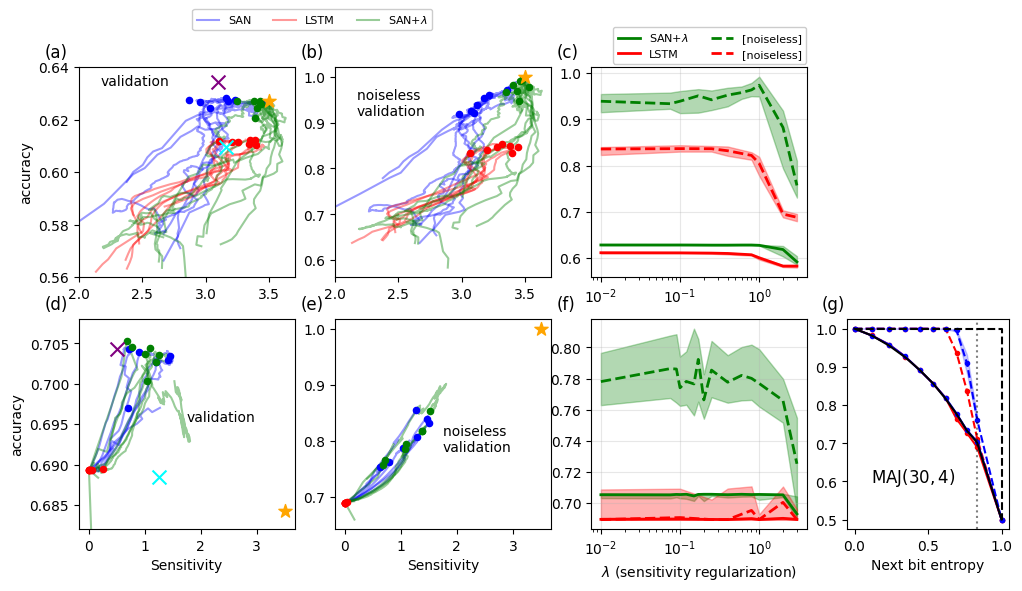

In [7]:
# First subplots: model error versus sensitivity regularization

# Define metrics to plot
metrics = ['val_acc', 'noiseless_val_acc']
metric_names = ["", "[noiseless]"]
ls_by_metric = ['-', '--'] # linestyle by metric

key_to_compare = 'lambda_sens'
start_later = 1 # this cuts out very small lambda values (10^-3)

colors = {"RNN": 'r', "SAN": 'b', "SAN_reg": 'g'} # RNN, SAN, SAN_reg

proper_labels = {"RNN": "LSTM", "SAN": "SAN", "SAN_reg": f"SAN+$\lambda$"}


fig = plt.figure(figsize=(12, 6))
gs = fig.add_gridspec(2, 4, height_ratios=[1, 1], width_ratios=[4, 4, 4, 3])
axes = gs.subplots()
axes[0,3].set_visible(False)

# COLUMN 0-1: NOISELESS VALIDATION ERROR TRACE PLOTS
val_column = 0
noiseless_val_column = 1
num_models = counterexample_san_df["model_num"].max() + 1
moving_average_window = 10
trace_alpha = 0.4

n_keep = 7 # number of traces to keeep

titles = ["Validation error", "Training error", "Noiseless validation error"]

for i, (name, df_dict) in enumerate(all_trace_dfs.items()):
    for k, (model_name, df) in enumerate(df_dict.items()): # iterate over RNN, SAN, SAN_reg
        color = colors.get(model_name)
        # Selecting traces to display.
        # Right now, I choose which traces to display by the median validation accuracy
        max_val_acc = df.groupby("model_num")["val_acc"].max()
        ordered = max_val_acc.sort_values(ascending=False)
        # get the 'n_keep' model_nums closest to the middle of `ordered`
        middle_idx = len(ordered) // 2
        start_idx = max(0, middle_idx - n_keep // 2)
        end_idx = min(len(ordered), start_idx + n_keep)
        to_keep = ordered.index[start_idx:end_idx].values
        # to_keep = ordered.index[:n_keep].values # this will order purely by best validation accuracy

        for trace_idx, j in enumerate(to_keep):
            if trace_idx == 0:
                label = proper_labels[model_name]
            else:
                label = None

            df_temp = df[df["model_num"] == j]
            df_temp = df_temp.reset_index(drop=True) # reset the indices since we have detached from the dataframe containing all other samples
            ref_idx = df_temp['val_acc'].idxmax() + 1 # +1 to include the maximum value
            
            sens_line   = df_temp["sensitivity"].values[:ref_idx]
            val_line    = df_temp["val_acc"].values[:ref_idx]
            noiseless_val_line = df_temp["noiseless_val_acc"].values[:ref_idx]

            x, y_val = moving_average(sens_line, val_line, moving_average_window)
            x, y_noiseless_val = moving_average(sens_line, noiseless_val_line, moving_average_window)
            axes[i, val_column].plot(x, y_val, color=color, alpha=trace_alpha, label=label)
            axes[i, val_column].scatter(sens_line[-1], y_val[-1], marker='o', s=20, color=color, zorder=10)  
            axes[i, noiseless_val_column].plot(x, y_noiseless_val, color=color, alpha=trace_alpha)
            axes[i, noiseless_val_column].scatter(x[-1], y_noiseless_val[-1], marker='o', s=20, color=color, zorder=10)  
            
# Now overlay the theory points
for k, dct in enumerate([counterexample_analysis_package, majority_analysis_package]):
    true_sens = dct["true_sens"]
    f_val_err = dct["f_val_err"]
    f_tr_err = dct["f_tr_err"]
    sens_Ztrlookup = dct["sens_Ztrlookup"]
    sens_Zvallookup = dct["sens_Zvallookup"]
    err_Ztrlookup_on_Zval = dct["err_Ztrlookup_on_Zval"]
    err_Ztrlookup_on_Ztrain = dct["err_Ztrlookup_on_Ztrain"]
    err_Zvallookup_on_Zval = dct["err_Zvallookup_on_Zval"]
    axes[k, val_column].scatter(true_sens, 1 - f_val_err, c='orange', marker="*", s=100, zorder=20)
    axes[k, val_column].scatter(sens_Ztrlookup, 1 - err_Ztrlookup_on_Zval, c='cyan', marker="x", s=100, zorder=20) # lookup Ztrain, eval on Zval
    axes[k, val_column].scatter(sens_Zvallookup, 1 - err_Zvallookup_on_Zval, c='purple', marker="x", s=100, zorder=20 ) # lookup Ztrain, eval on Zval
    axes[k, noiseless_val_column].scatter(true_sens, 1, c='orange', marker="*", s=100, zorder=20)

axes[0, val_column].legend(ncol=3, bbox_to_anchor=(0.5, 1.15), loc='lower left', framealpha=1, fontsize=8)

# COLUMN 2 lambda regularization plots
reg_column = 2
for i, (name, df_dict) in enumerate(all_dfs.items()):
    # overlay RNN and SAN performance, for both noiselss and noisy val loss
    for k, metric in enumerate(metrics):
        # overlay RNN and SAN
        for j, (model_name, df) in enumerate(df_dict.items()):
            # Calculate statistics for each lambda_sens value
            grouped = df.groupby(key_to_compare)[metric]
            median_acc = grouped.median().reset_index()
            q25_acc = grouped.quantile(0.25).reset_index()
            q75_acc = grouped.quantile(0.75).reset_index()

            # formatting
            color = colors.get(model_name)
            linestyle = ls_by_metric[k]
            if k == 0:
                label = proper_labels[model_name]
            elif k == 1:
                label = "[noiseless]"

            # Plot median and IQ
            axes[i, reg_column].plot(median_acc[key_to_compare][start_later:], median_acc[metric][start_later:], 
                        color=color, linewidth=2, label=label, linestyle=linestyle)
            axes[i, reg_column].fill_between(median_acc[key_to_compare][start_later:], 
                        q25_acc[metric][start_later:], q75_acc[metric][start_later:], 
                        alpha=0.3, color=color)
        
    axes[i, reg_column].grid(True, alpha=0.3)
    axes[i, reg_column].semilogx()


# axes adjustments
label_fontsize = 10
for i in [val_column, noiseless_val_column]:
    axes[0,i].set_xlim(2, 3.7)
    axes[1,i].set_xlabel("Sensitivity")
axes[0, reg_column].legend(ncol=2, bbox_to_anchor=(0.55, .99), loc='lower center', framealpha=1, fontsize=8)

axes[0,val_column].text(0.1, 0.9, "validation", fontsize=label_fontsize, ha='left', va='bottom', transform=axes[0,val_column].transAxes)
axes[0,noiseless_val_column].text(0.1, 0.9, "noiseless \nvalidation", fontsize=label_fontsize, ha='left', va='top', transform=axes[0,noiseless_val_column].transAxes)
axes[1,val_column].text(0.5, 0.5, "validation", fontsize=label_fontsize, ha='left', va='bottom', transform=axes[1,val_column].transAxes)
axes[1,noiseless_val_column].text(0.5, 0.5, "noiseless \nvalidation", fontsize=label_fontsize, ha='left', va='top', transform=axes[1,noiseless_val_column].transAxes)

for row in range(2):
    axes[row,0].set_ylabel("accuracy", fontsize=label_fontsize)
axes[1, reg_column].set_xlabel(f'$\lambda$ (sensitivity regularization)', fontsize=label_fontsize)

axes[0,val_column].set_ylim(0.56, 0.64)
axes[1,val_column].set_ylim(0.682, 0.708)
# axes[1,val_column].set_ylim(0.682, 1)


# last column: MAJ(30, 4) underwhelming performance
i_maj_30_4 = 3
SPREADSHEET_NAME = SPREADSHEET_NAMES[i_maj_30_4]
bf_vals = BF_VALS[i_maj_30_4]
sheetname_template = NAME_TEMPLATES[i_maj_30_4]
bf_vals = BF_VALS[i_maj_30_4]
df_all = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[i_maj_30_4]}.csv")
df_ana = pd.read_csv(f"./processed/{SPREADSHEET_NAMES[i_maj_30_4]}_ana.csv")
axes[1, 3] = make_san_vs_rnn_plot(df_all, df_ana, bf_vals, axes[1, 3], mode='entropy')
axes[1, 3].text(0.15, 0.3, DATASET_NAMES[i_maj_30_4], ha='left', va='top', fontsize=12, transform=axes[1, 3].transAxes)

# label the subplots (a)-(g) in the top left corner
labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']
for i, ax in enumerate(axes[0,:3]):
    ax.text(-0.16, 1.03, labels[i], ha='left', va='bottom', fontsize=12, transform=ax.transAxes)
for i, ax in enumerate(axes[1,:]):
    ax.text(-0.16, 1.03, labels[i+3], ha='left', va='bottom', fontsize=12, transform=ax.transAxes)

bitflip_319_entropy = df_ana[df_ana["bf"] == .319]["entropy"].values[0]
axes[1,3].axvline(bitflip_319_entropy, c='k', ls=':', alpha=0.5)


# save figure
fig.savefig(f"./figures/fig3.pdf", bbox_inches='tight')



### APPENDIX PLOTS

first plot: full traces, for train, noisy val, noiseless val

model num 15 ref_idx 140
model num 8 ref_idx 80
model num 14 ref_idx 157
model num 7 ref_idx 15
model num 3 ref_idx 20
model num 15 ref_idx 65
model num 8 ref_idx 49
model num 14 ref_idx 37
model num 7 ref_idx 11
model num 3 ref_idx 163
model num 15 ref_idx 317
model num 8 ref_idx 225
model num 14 ref_idx 184
model num 7 ref_idx 84
model num 3 ref_idx 354
model num 15 ref_idx 27
model num 8 ref_idx 194
model num 14 ref_idx 21
model num 7 ref_idx 50
model num 3 ref_idx 101
model num 15 ref_idx 258
model num 8 ref_idx 59
model num 14 ref_idx 71
model num 7 ref_idx 51
model num 3 ref_idx 299
model num 15 ref_idx 1
model num 8 ref_idx 141
model num 14 ref_idx 1
model num 7 ref_idx 40
model num 3 ref_idx 1


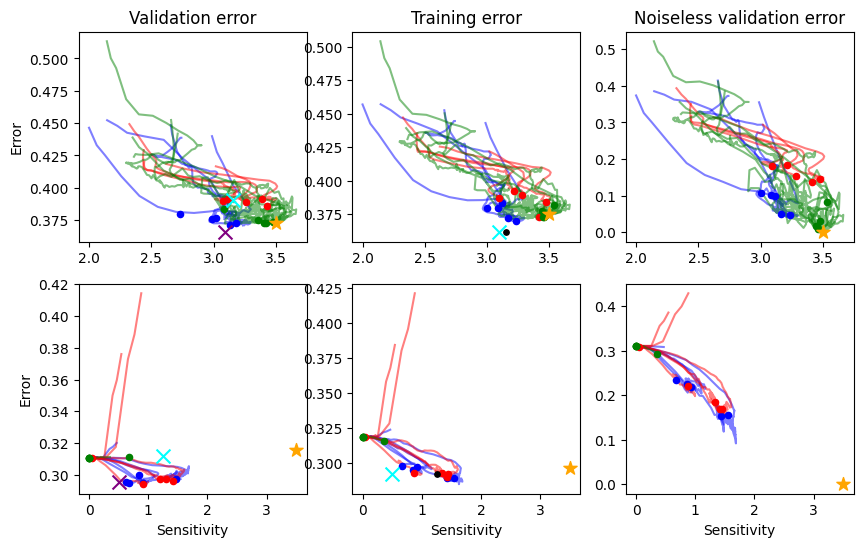

In [14]:
num_models = counterexample_san_df["model_num"].max() + 1

np.random.seed(5680)
n_keep = 5
random_keep = list(np.random.choice(list(range(19)), replace=False, size=n_keep))
random_keep = [int(x) for x in random_keep]
good_idx = {
    "RNN": random_keep,
    "SAN": random_keep,
    "SAN_reg": random_keep
}
titles = ["Validation error", "Training error", "Noiseless validation error"]
fig, axes = plt.subplots(2, 3, figsize=(10, 6))
colors = {"RNN": 'r', "SAN": 'b', "SAN_reg": 'g'} # RNN, SAN, SAN_reg

for i, (name, df_dict) in enumerate(all_trace_dfs.items()):
    for k, (model_name, df) in enumerate(df_dict.items()): # iterate over RNN, SAN, SAN_reg
        # if k != 2:
        #     continue
        color = colors.get(model_name)
        for j in random_keep:
            df_temp = df[df["model_num"] == j]
            df_temp = df_temp.reset_index(drop=True) # reset the indices since we have detached from the dataframe containing all other samples
            ref_idx = df_temp['val_acc'].idxmax() + 1 # +1 to include the maximum value
            print("model num", j, "ref_idx", ref_idx)
            
            sens_line   = df_temp["sensitivity"].values[:ref_idx]
            val_line    = 1 - df_temp["val_acc"].values[:ref_idx]
            train_line  = 1 - df_temp["train_acc"].values[:ref_idx]
            noiseless_val_line = 1 - df_temp["noiseless_val_acc"].values[:ref_idx]
            # col 0 is val, col 1 is train, col 2 is noiseless val
            x = sens_line
            y_val = val_line
            y_train = train_line
            y_noiseless_val = noiseless_val_line
            x, y_val = moving_average(x, y_val, 5)
            x, y_train = moving_average(x, y_train, 5)
            x, y_noiseless_val = moving_average(x, y_noiseless_val, 5)
            # print(x, y_val)
            axes[i, 0].plot(x, y_val, color=color, alpha=0.5)
            axes[i, 0].scatter(sens_line[-1], y_val[-1], marker='o', s=20, color=color, label=model_name, zorder=10)  # ending point
            axes[i, 1].plot(x, y_train, color=color, alpha=0.5)
            axes[i, 1].scatter(x[-1], y_train[-1], marker='o', s=20, color=color, label=model_name, zorder=10)  # ending point
            axes[i, 2].plot(x, y_noiseless_val, color=color, alpha=0.5)
            axes[i, 2].scatter(x[-1], y_noiseless_val[-1], marker='o', s=20, color=color, label=model_name, zorder=10)  # ending point
            
# Now overlay the theory points
for k, dct in enumerate([counterexample_analysis_package, majority_analysis_package]):
    true_sens = dct["true_sens"]
    f_val_err = dct["f_val_err"]
    f_tr_err = dct["f_tr_err"]
    sens_Ztrlookup = dct["sens_Ztrlookup"]
    sens_Zvallookup = dct["sens_Zvallookup"]
    err_Ztrlookup_on_Zval = dct["err_Ztrlookup_on_Zval"]
    err_Ztrlookup_on_Ztrain = dct["err_Ztrlookup_on_Ztrain"]
    err_Zvallookup_on_Zval = dct["err_Zvallookup_on_Zval"]
    axes[k, 0].scatter(true_sens, f_val_err, c='orange', marker="*", s=100, zorder=20)
    axes[k, 0].scatter(sens_Ztrlookup, err_Ztrlookup_on_Zval, c='cyan', marker="x", s=100, zorder=20, label="Ztr loookup on Zval") # lookup Ztrain, eval on Zval
    axes[k, 0].scatter(sens_Zvallookup, err_Zvallookup_on_Zval, c='purple', marker="x", s=100, zorder=20, label="Zval loookup on Zval") # lookup Ztrain, eval on Zval
    axes[k, 1].scatter(true_sens, f_tr_err, c='orange', marker="*", s=100, zorder=20)
    axes[k, 1].scatter(sens_Ztrlookup, err_Ztrlookup_on_Ztrain, c='k', marker=".", s=60, zorder=20) # lookup Ztrain, eval on Ztr
    axes[k, 1].scatter(sens_Zvallookup, err_Ztrlookup_on_Ztrain, c='cyan', marker="x", s=100, zorder=20, label="Ztr loookup on Ztr") # lookup Ztrain, eval on Zval
    axes[k, 2].scatter(true_sens, 0, c='orange', marker="*", s=100, zorder=20)

for ax in axes[1,:]:
    ax.set_xlabel("Sensitivity")
for ax in axes[:,0]:
    ax.set_ylabel("Error")
for p, ax in enumerate(axes[0,:]):
    ax.set_title(titles[p])

# axes[0,0].legend()
# for ax in axes.flatten():
#     ax.grid(True, alpha=0.3)
#     ax.legend()

